In [1]:
import time
import numpy as np
import pymc3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/legmint/.local/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
rng = np.random.RandomState(42)

source : http://approximateinference.org/2017/accepted/Zinkov2017.pdf
source : https://towardsdatascience.com/implement-expectation-maximization-em-algorithm-in-python-from-scratch-f1278d1b9137

In [3]:
df = pd.read_csv("../data/X_station_day.csv")

In [4]:
df.rename(columns={"precipitations": "current_precipitations"}, inplace=True)

## EM
 M-step :

$$ \pi = \frac{\sum_{i=1}^{n}\mathcal{Q}(y^i=1|x^i)}{n} $$

$$ \mu_j = \frac{\sum_{i=1}^{n}x^i\mathcal{Q}(y^i=j|x^i)}{\sum_{i=1}^{n}\mathcal{Q}(y^i=j|x^i)} $$

$$ \Sigma_j = \frac{\sum_{i=1}^{n}\mathcal{Q}(y^i=j|x^i)(x^i-\mu_j)(x^i-\mu_j)^T}{\sum_{i=1}^{n}\mathcal{Q}(y^i=j|x^i)} $$

In [5]:
class EM():
    def __init__(self, x: np.ndarray, nb_dist=2, split_ratio=0.1, threshold=0.01, minimum_sigma=1e-5, talk=False):
        self.talk=talk # whether to display informations or not
        self.threshold = threshold # threshold ratio to trigger stop_fitting
        self.stop_fitting = False

        self.sample_idx = rng.choice(np.arange(x.shape[0]),
                                     replace=False,
                                     size=int(x.shape[0]*split_ratio))
        self.sample_x = x[self.sample_idx]
        self.x = np.delete(x, self.sample_idx, axis=0)

        self.nb_dist = nb_dist
        self.mu, self.sigma, self.w = self.init_params()
        self.history = self.init_h()
        self.r = None

        self.minimum_sigma = minimum_sigma

    def init_params(self):
        mu = rng.normal(loc=np.mean(self.sample_x),
                        scale=5,
                        size=self.nb_dist)
        sigma = rng.normal(loc=np.sqrt(np.var(self.sample_x)),
                           scale=0.5,
                           size=self.nb_dist)
        w = np.abs(rng.normal(loc=1,
                              scale=0.2,
                              size=self.nb_dist))
        w /= w.sum()
        if self.talk :
            print("Initial parameters :")
            print("\t - mu : {}".format(np.round(mu,2)))
            print("\t - sigma : {}".format(np.round(sigma,2)))
            print("\t - w : {}".format(np.round(w,2)))
        return mu, sigma, w

    def init_h(self):
        history = {"mu": [self.mu],
                   "sigma": [self.sigma],
                   "w": [self.w]}
        return history

    def update_h(self):
        self.history["mu"].append(self.mu)
        self.history["sigma"].append(self.sigma)
        self.history["w"].append(self.w)

    def e_step(self):
        x = self.x[None, :]
        mu = self.mu[:, None]
        sigma = self.sigma[:, None]
        # r is the probability of each point of x given the normal distribution N(mu,sigma)
        self.r = stats.norm.pdf(x, mu, sigma)
        self.r = self.r / self.r.sum(axis=0)

    def m_step(self):
        n = self.x.shape[0]
        self.w = np.sum(self.r, axis=1) / n
        self.mu = np.sum(self.x * self.r, axis=1) / np.sum(self.r, axis=1)
        sigma = []
        for j in range(self.nb_dist):
            sigma.append(
                np.sqrt(np.sum(self.r[j, :] * (self.x - self.mu[j]) * (self.x - self.mu[j])) / np.sum(self.r[j, :])))
            if sigma[-1] < self.minimum_sigma :
                print("WARNING : sigma < minimum_sigma - {:.7f} < {:.7f}".format(sigma[-1],self.minimum_sigma).ljust(70), end="\r")
                sigma[-1] = self.minimum_sigma
        self.sigma = np.array(sigma)

    def fit(self, max_iters=10, plot=False):
        self.stop_fitting = False
        for i in range(max_iters):
            if self.talk and i % int(max_iters//100+1) == 0 :
                print("{} %".format(int(i/max_iters*100)).rjust(5), end="\r")

            self.e_step()
            self.m_step()
            self.update_h()

            self.check_change()
            if self.stop_fitting :
                break
        print("\n")
        if self.talk :
            if self.stop_fitting :
                print("Threshold reached, less than {} % difference.".format(self.threshold*100))
            else :
                print("100 %")
        if plot :
            self.plot_progression()

    def check_change(self):
        mu_old = self.history["mu"][-2]
        sigma_old = self.history["sigma"][-2]
        w_old = self.history["w"][-2]
        if any(self.mu == 0) :
            delta_mu = np.max(np.abs((mu_old-self.mu)/(self.mu+1)))
        else :
            delta_mu = np.max(np.abs((mu_old-self.mu)/self.mu))
        delta_sigma = np.max(np.abs((sigma_old-self.sigma)/self.sigma))
        if any(self.w == 0) :
            delta_w = np.max(np.abs((w_old-self.w)/(self.w+1)))
        else :
            delta_w = np.max(np.abs((w_old-self.w)/self.w))
        delta = max(delta_mu,delta_sigma,delta_w)
        if delta < self.threshold :
            self.stop_fitting = True

    def plot_step(self, step_index, figsize=(10, 7)):
        mu = self.history["mu"][step_index]
        sigma = self.history["sigma"][step_index]
        w = self.history["w"][step_index]

        plt.figure(figsize=figsize)
        plt.title("step_index : {}".format(step_index))
        abscisse = np.linspace(self.x.min(), self.x.max(), 1001)
        sns.histplot(self.x, bins=50, alpha=0.2, color="red", stat="probability")
        for j in range(self.nb_dist):
            plt.plot(abscisse, w[j] * stats.norm.pdf(abscisse, mu[j], sigma[j]))
        plt.show()

    def plot_params(self, figsize=(10, 7), title="Current parameters"):
        plt.figure(figsize=figsize)
        plt.title(title)
        abscisse = np.linspace(self.x.min(), self.x.max(), 1001)
        sns.histplot(self.x, bins=50, alpha=0.2, color="red", stat="probability")
        for j in range(self.w.shape[0]):
            plt.plot(abscisse, self.w[j] * stats.norm.pdf(abscisse, self.mu[j], self.sigma[j]))
        plt.show()

    def plot_progression(self, figsize=(20, 6), title="Expectation Maximization", log_scale=False):
        abscisse = np.linspace(self.x.min(), self.x.max(), 1001)

        plt.figure(figsize=figsize)
        ax0 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), rowspan=3)
        ax1_0 = plt.subplot2grid(shape=(3, 3), loc=(0, 1))
        ax1_1 = plt.subplot2grid(shape=(3, 3), loc=(1, 1))
        ax1_2 = plt.subplot2grid(shape=(3, 3), loc=(2, 1))
        ax2 = plt.subplot2grid(shape=(3, 3), loc=(0, 2), rowspan=3)

        ax0.set_title("Initialization")
        mu_init = self.history["mu"][0]
        sigma_init = self.history["sigma"][0]
        w_init = self.history["w"][0]
        sns.histplot(self.x, bins=50, alpha=0.2, color="cyan", stat="probability", ax=ax0)
        for j in range(self.nb_dist):
            ax0.plot(abscisse, w_init[j] * stats.norm.pdf(abscisse, mu_init[j], sigma_init[j]))

        ax1_0.set_title("parameters")
        for i in range(self.nb_dist):
            sns.lineplot(x=np.arange(len(self.history["mu"])),
                         y=np.array(self.history["mu"])[:,i],
                         ax=ax1_0,
                         label="{}".format(i),
                         palette=sns.color_palette("hls", 8))
        ax1_0.set_ylabel("mu")
        ax1_0.set_xticks([])
        for i in range(self.nb_dist):
            sns.lineplot(x=np.arange(len(self.history["sigma"])),
                         y=np.array(self.history["sigma"])[:,i],
                         ax=ax1_1,
                         label="{}".format(i),
                         palette=sns.color_palette("hls", 8))
        ax1_1.set_ylabel("sigma")
        ax1_1.set_xticks([])
        for i in range(self.nb_dist):
            sns.lineplot(x=np.arange(len(self.history["w"])),
                         y=np.array(self.history["w"])[:,i],
                         ax=ax1_2,
                         label="{}".format(i),
                         palette=sns.color_palette("hls", 8))
        ax1_2.set_ylabel("w")
        ax1_2.set_xlabel("steps")

        ax2.set_title("After {} steps".format(len(self.history["mu"])-1))
        sns.histplot(self.x, bins=50, alpha=0.2, color="cyan", stat="probability", ax=ax2)
        for j in range(self.w.shape[0]):
            ax2.plot(abscisse, self.w[j] * stats.norm.pdf(abscisse, self.mu[j], self.sigma[j]))

        y_lim_top = min(1, ax0.set_ylim(auto=True)[1], ax2.set_ylim(auto=True)[1])
        ax0.set_ylim(top=y_lim_top)
        ax2.set_ylim(top=y_lim_top)

        plt.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.savefig("EM_progression.jpg")
        plt.show()




	 wind_speed



Initial parameters :
	 - mu : [1.68]
	 - sigma : [1.65]
	 - w : [1.]
  0 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.01 s.


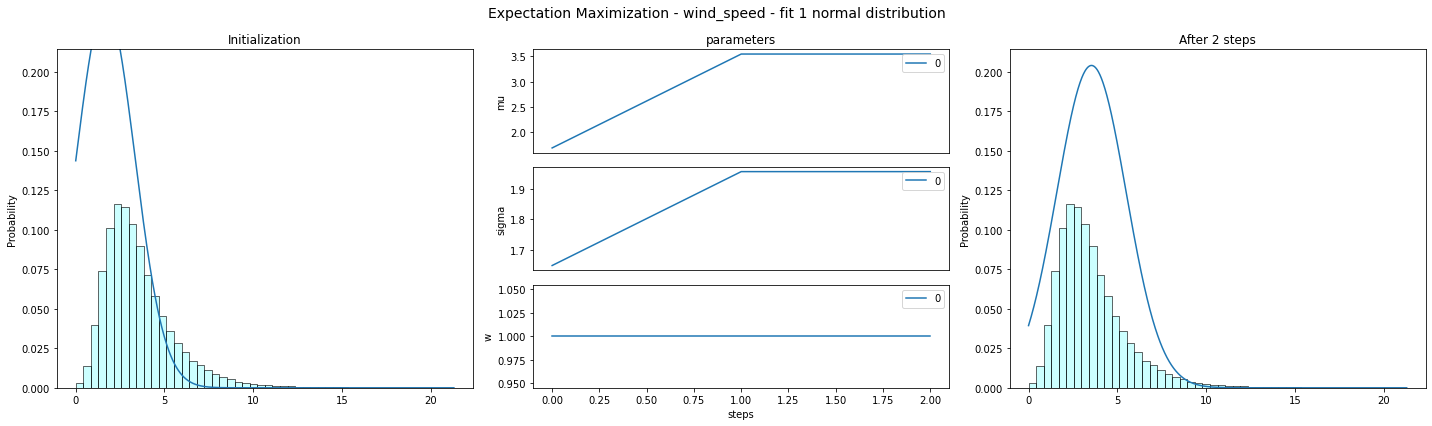

Initial parameters :
	 - mu : [10.38  2.12]
	 - sigma : [2.59 2.39]
	 - w : [0.48 0.52]
  1 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.09 s.


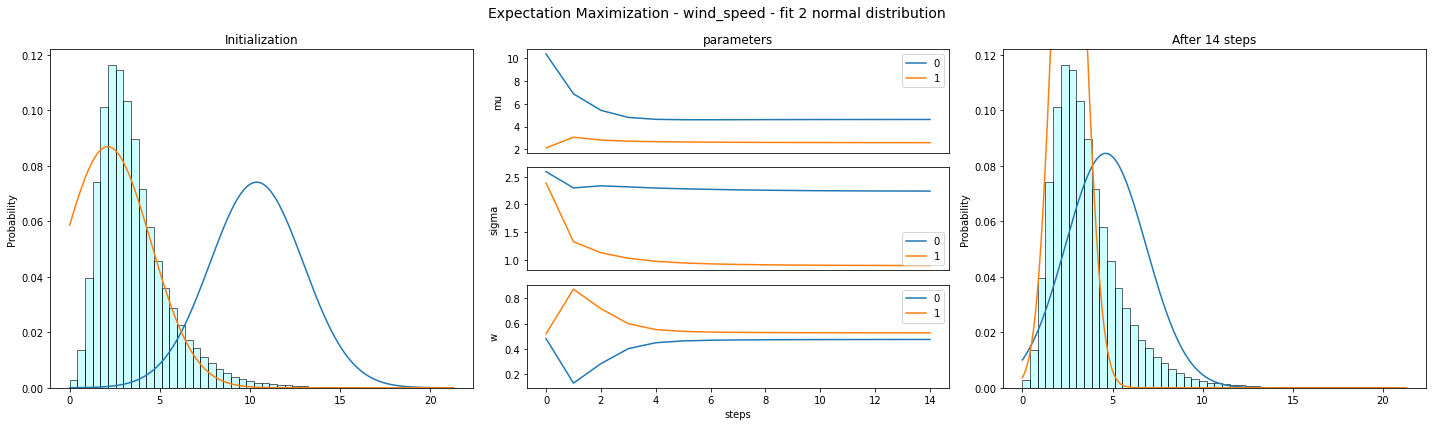

Initial parameters :
	 - mu : [ 1.08 14.01 -4.32]
	 - sigma : [1.62 1.75 0.7 ]
	 - w : [0.33 0.3  0.37]
  4 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.54 s.


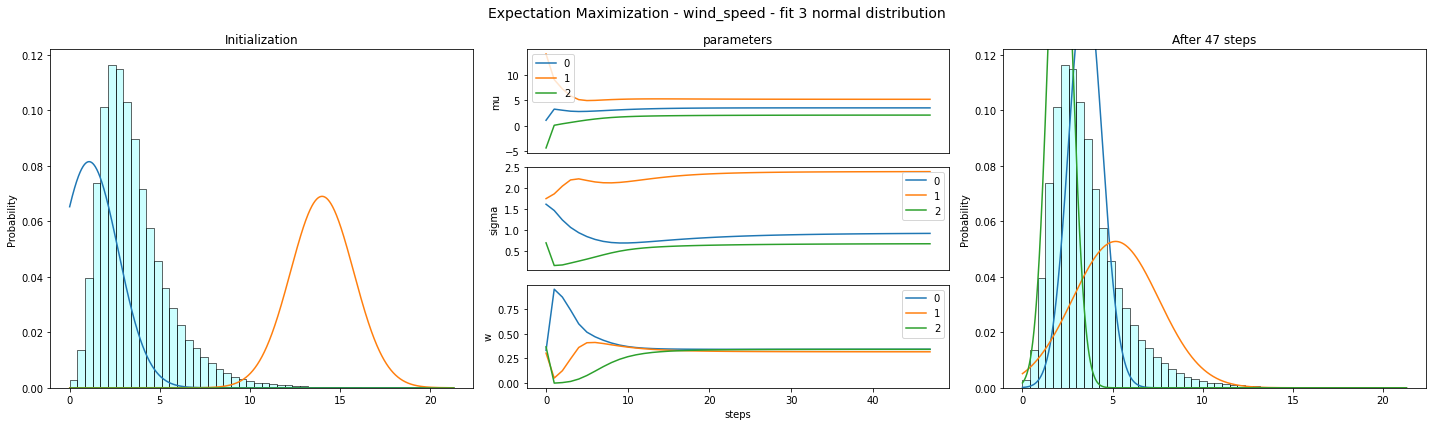

Initial parameters :
	 - mu : [13.64 -2.87  6.59 10.47]
	 - sigma : [2.08 1.5  1.28 1.17]
	 - w : [0.22 0.29 0.23 0.25]
  9 %

Threshold reached, less than 0.1 % difference.
elapsed : 2.11 s.


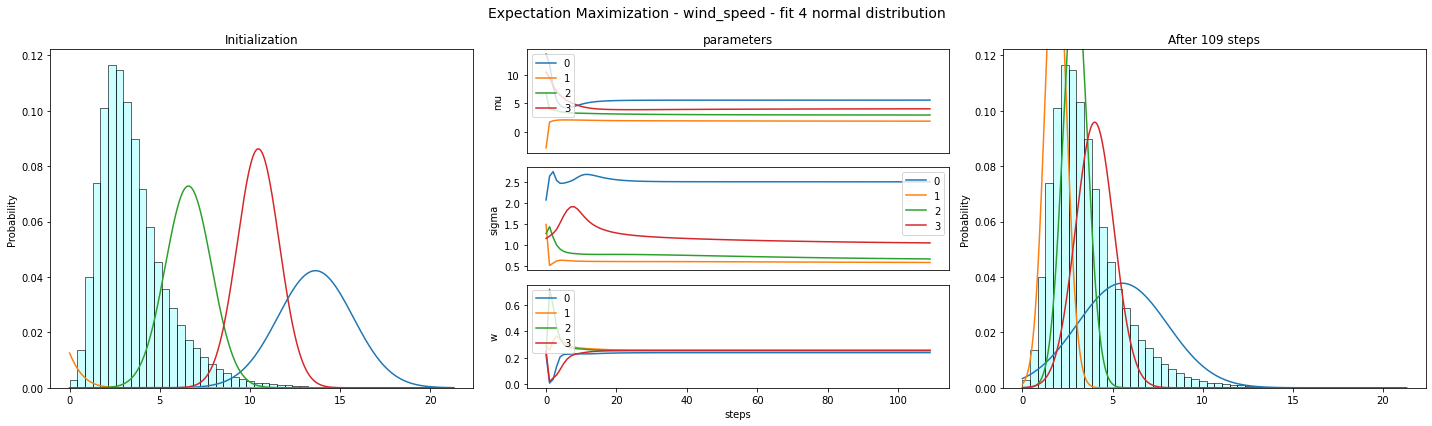




	 temperature



Initial parameters :
	 - mu : [283.37]
	 - sigma : [5.16]
	 - w : [1.]
  0 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.01 s.


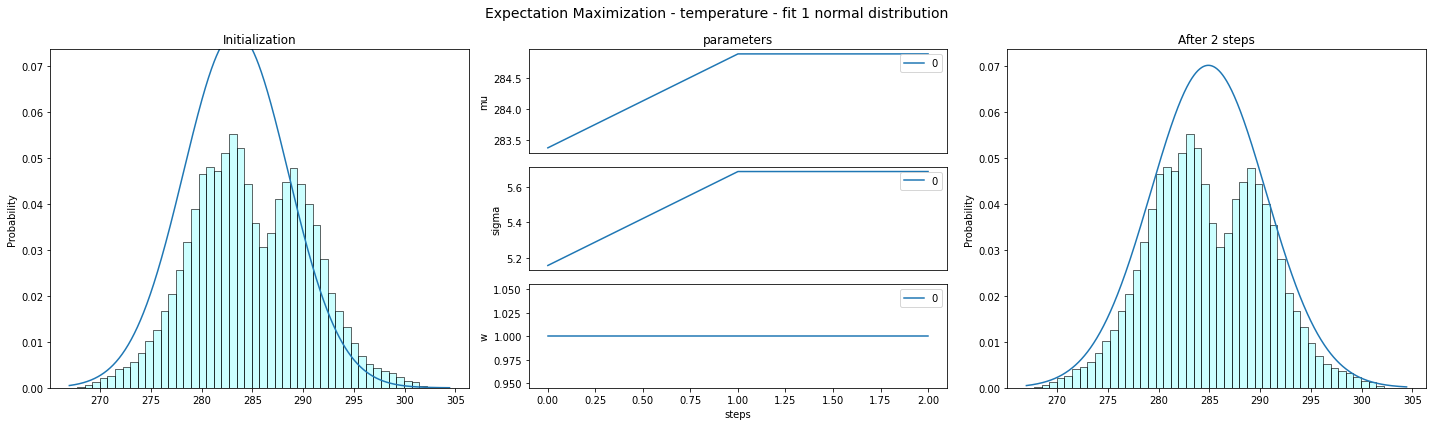

Initial parameters :
	 - mu : [291.39 295.17]
	 - sigma : [5.6 5.3]
	 - w : [0.6 0.4]
  4 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.38 s.


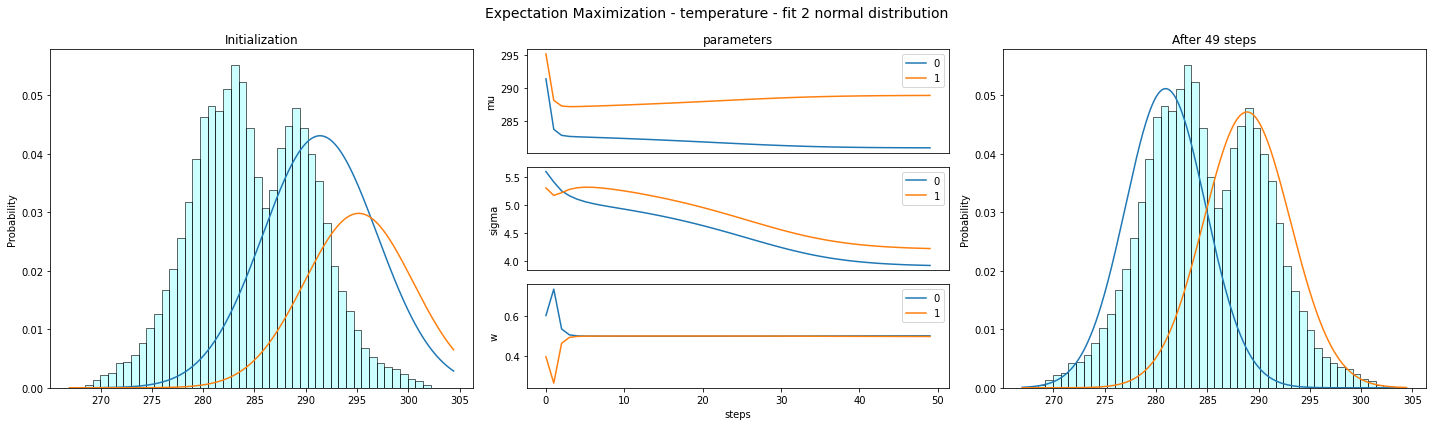

Initial parameters :
	 - mu : [289.69 286.41 293.97]
	 - sigma : [6.82 5.37 5.97]
	 - w : [0.28 0.29 0.43]
  6 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.69 s.


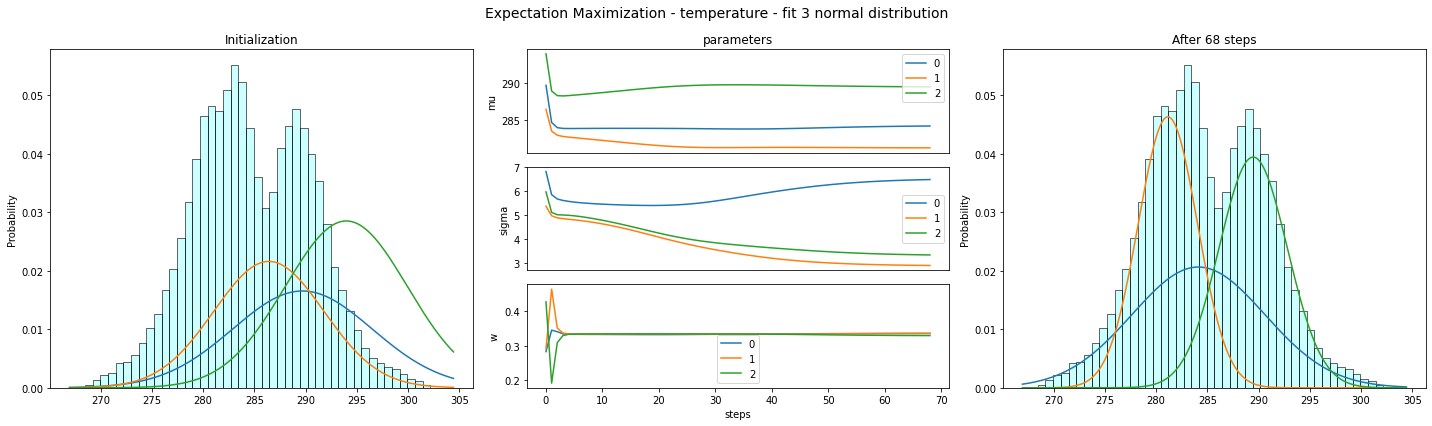

Initial parameters :
	 - mu : [278.53 284.56 288.67 287.51]
	 - sigma : [5.94 5.93 6.3  7.3 ]
	 - w : [0.26 0.25 0.25 0.24]
 15 %

Threshold reached, less than 0.1 % difference.
elapsed : 2.03 s.


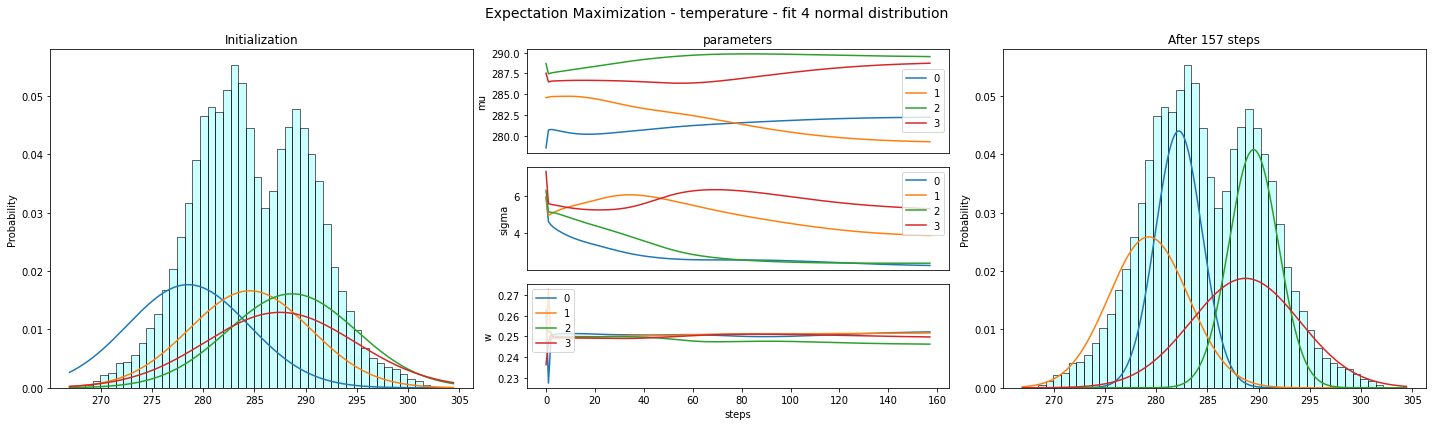




	 humidity



Initial parameters :
	 - mu : [77.53]
	 - sigma : [10.01]
	 - w : [1.]
  0 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.01 s.


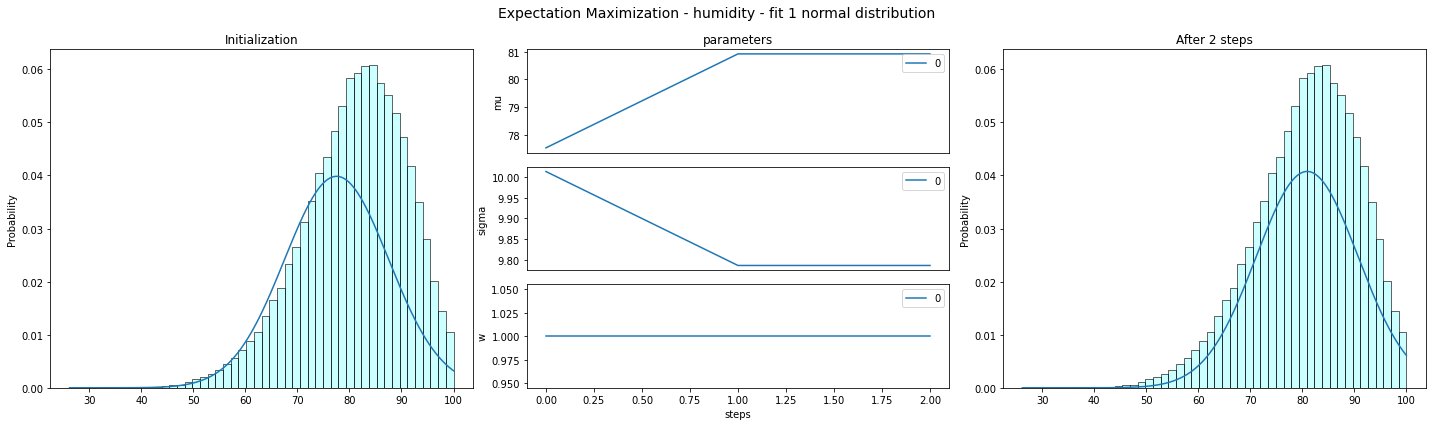

Initial parameters :
	 - mu : [81.9  69.18]
	 - sigma : [10.32 10.01]
	 - w : [0.56 0.44]
  2 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.16 s.


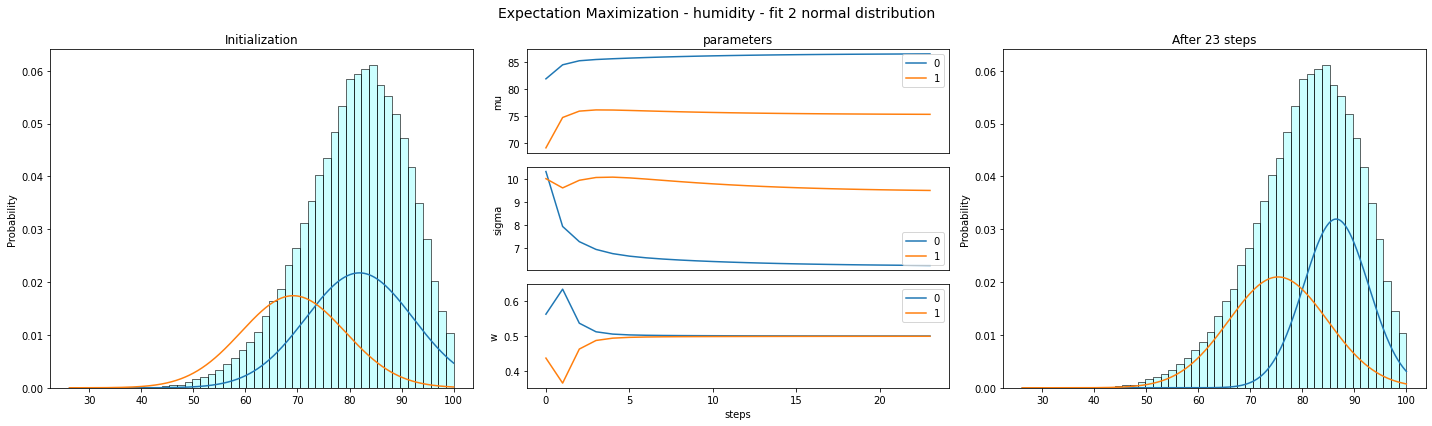

Initial parameters :
	 - mu : [83.34 80.43 75.57]
	 - sigma : [8.83 9.45 9.69]
	 - w : [0.4  0.29 0.31]
  8 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.95 s.


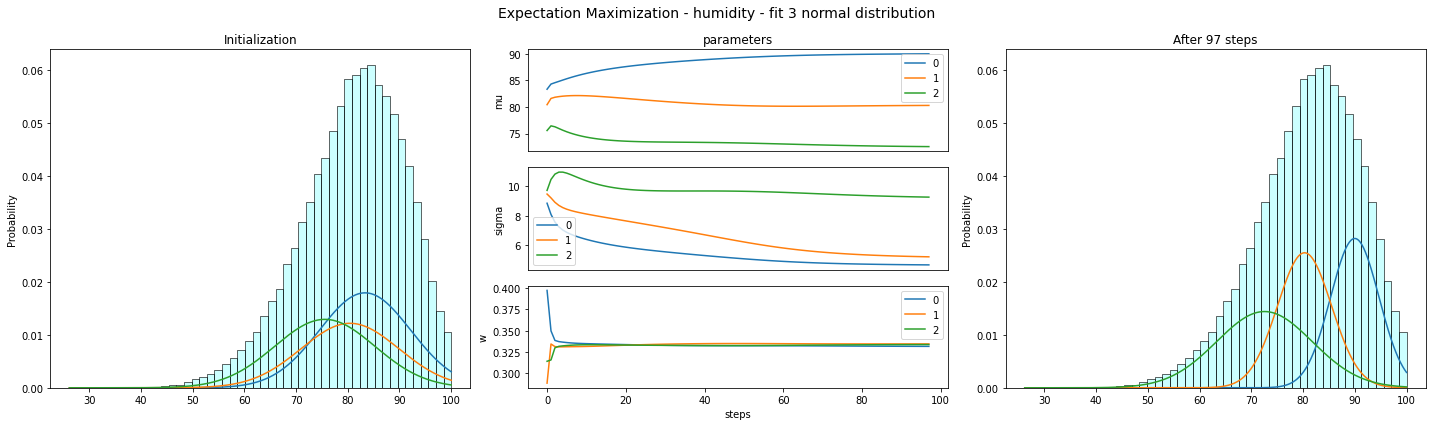

Initial parameters :
	 - mu : [79.32 78.04 80.93 85.36]
	 - sigma : [ 9.96 10.09  9.2  10.08]
	 - w : [0.27 0.24 0.2  0.3 ]
 19 %

Threshold reached, less than 0.1 % difference.
elapsed : 2.69 s.


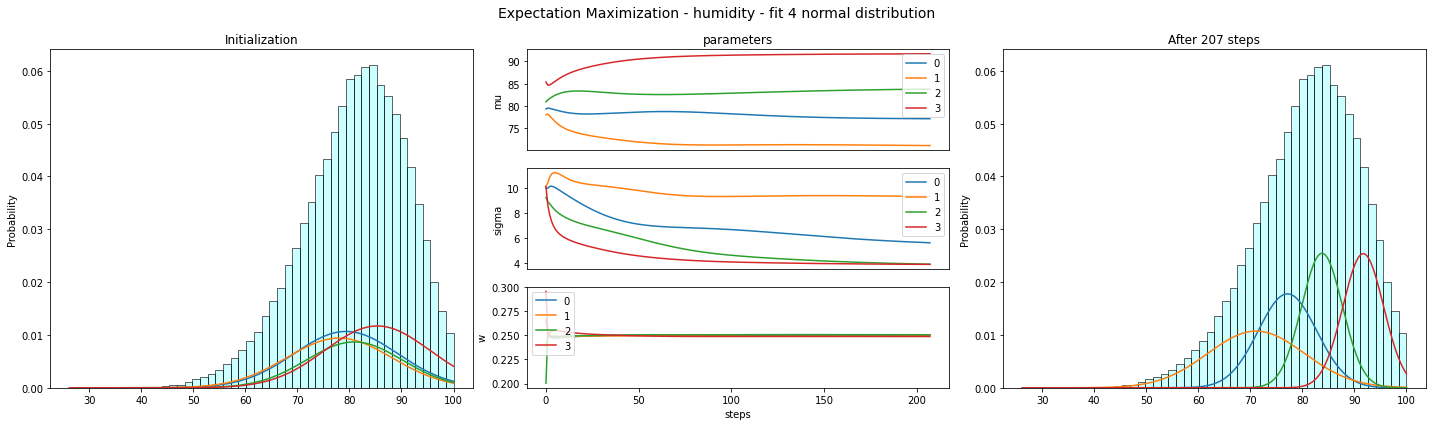




	 dew_point



Initial parameters :
	 - mu : [277.31]
	 - sigma : [5.85]
	 - w : [1.]
  0 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.01 s.


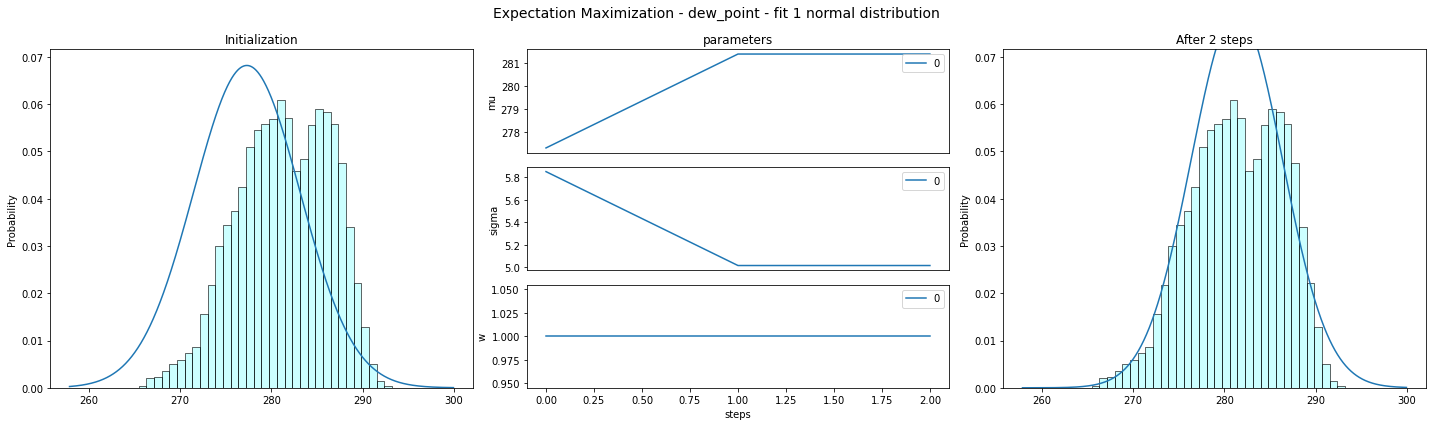

Initial parameters :
	 - mu : [278.47 287.51]
	 - sigma : [5.31 5.21]
	 - w : [0.49 0.51]
  1 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.16 s.


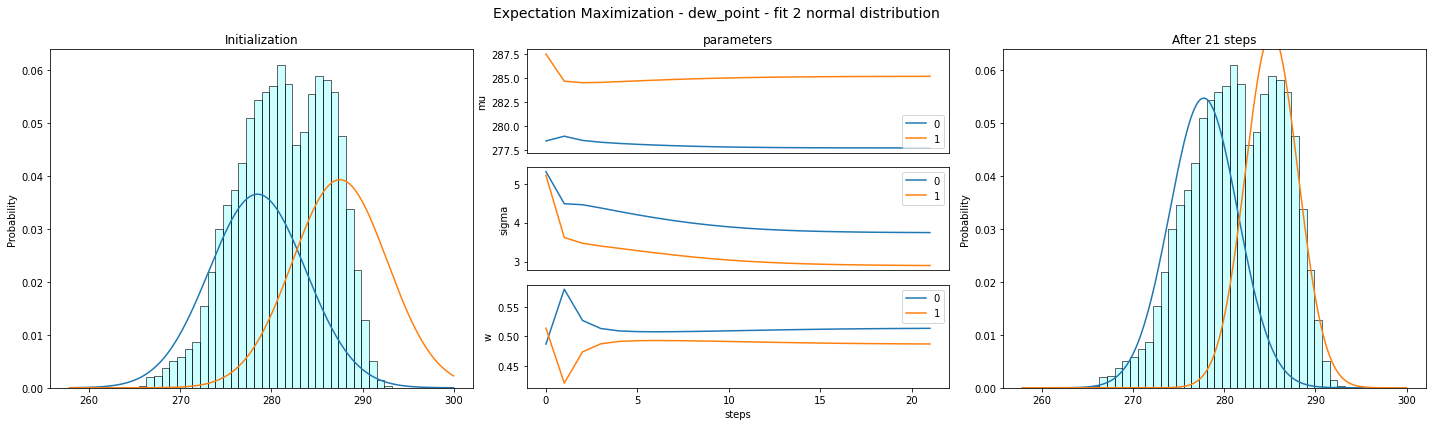

Initial parameters :
	 - mu : [291.15 290.15 294.19]
	 - sigma : [5.3  4.69 5.42]
	 - w : [0.29 0.47 0.23]
  8 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.94 s.


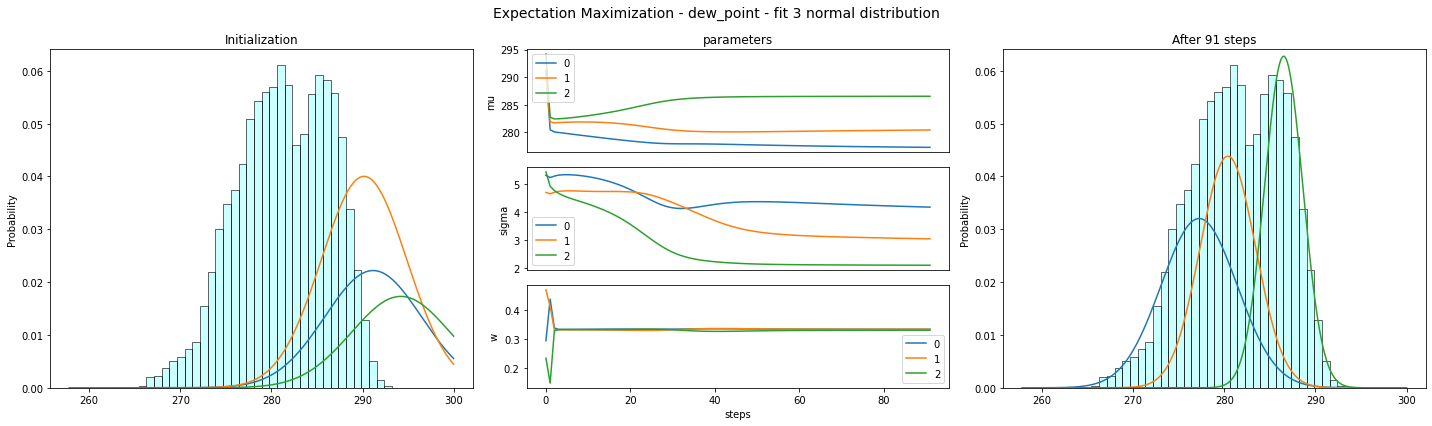

Initial parameters :
	 - mu : [288.79 283.11 283.92 285.18]
	 - sigma : [4.08 4.9  4.7  5.33]
	 - w : [0.27 0.29 0.16 0.28]
 11 %

Threshold reached, less than 0.1 % difference.
elapsed : 2.24 s.


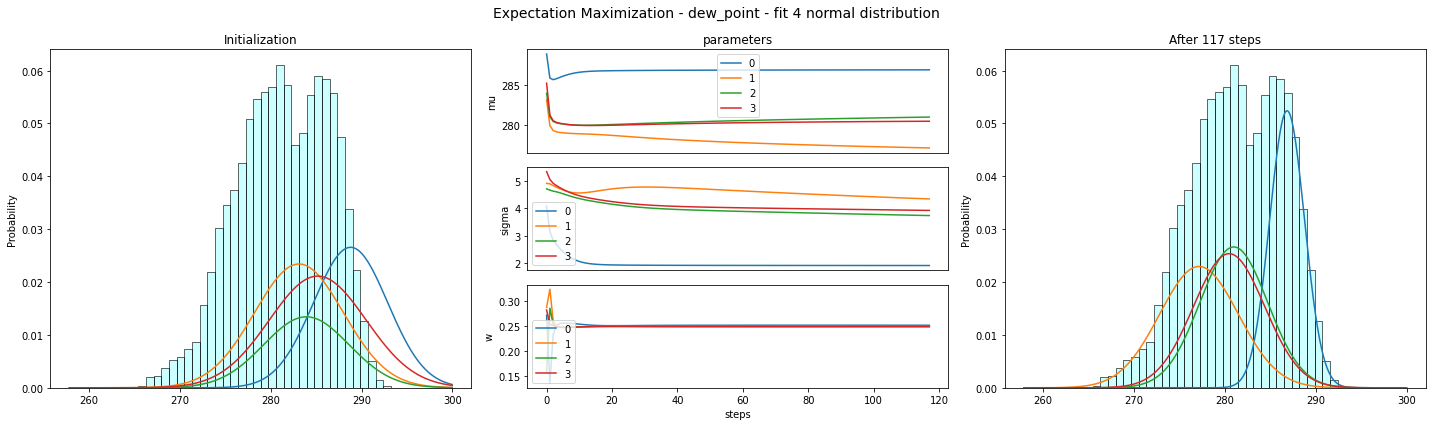




	 current_precipitations



Initial parameters :
	 - mu : [-6.31]
	 - sigma : [3.57]
	 - w : [1.]
  0 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.01 s.


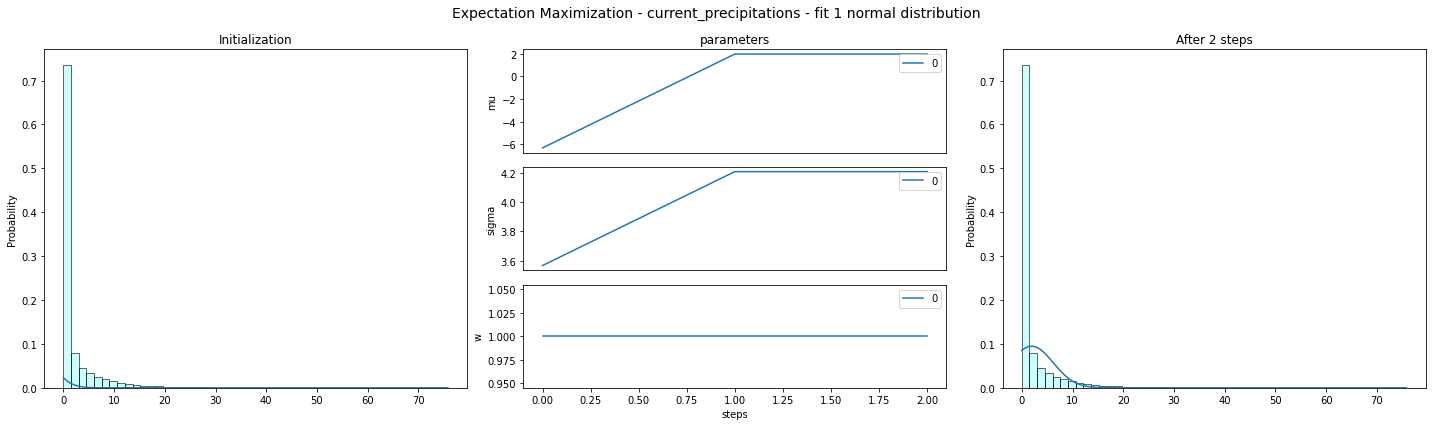

Initial parameters :
	 - mu : [4.9  9.44]
	 - sigma : [4.37 4.27]
	 - w : [0.52 0.48]
  2 %

Threshold reached, less than 0.1 % difference.
elapsed : 0.22 s.


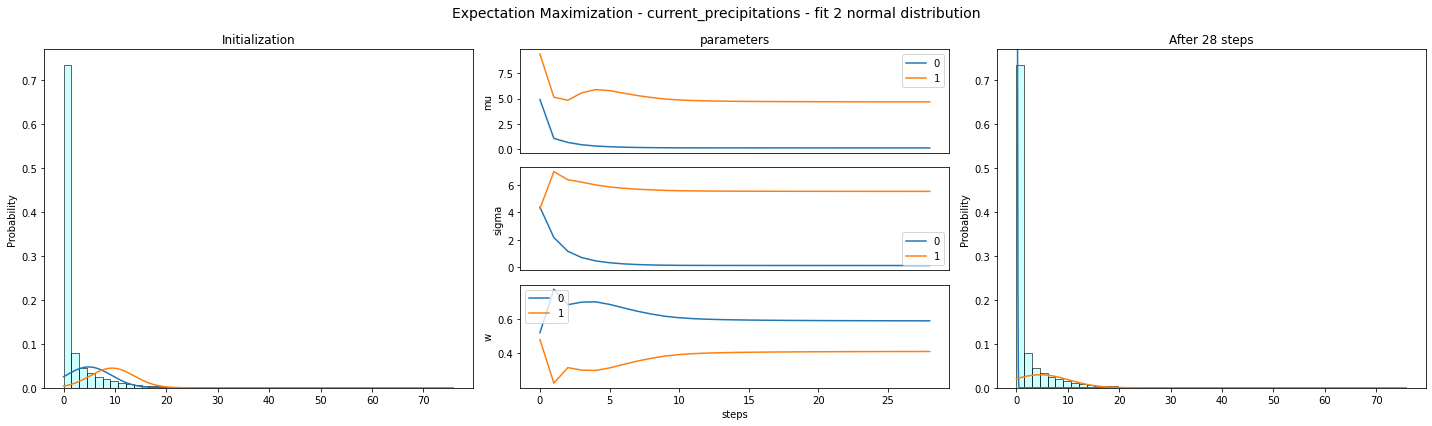

Initial parameters :
	 - mu : [4.93 2.85 1.54]
	 - sigma : [5.15 5.11 4.7 ]
	 - w : [0.36 0.33 0.31]

Threshold reached, less than 0.1 % difference.
elapsed : 1.13 s.


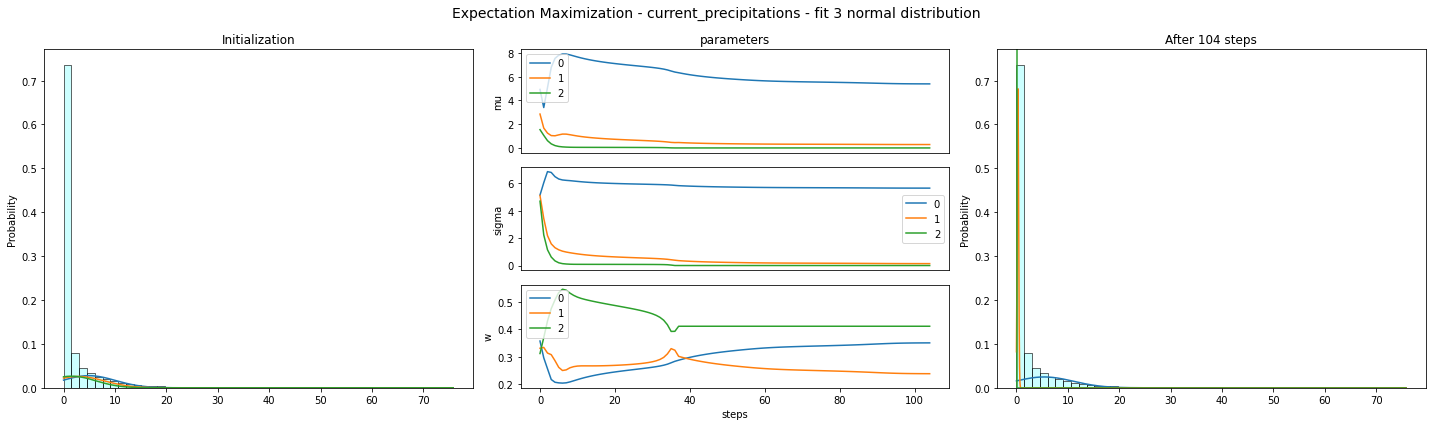

Initial parameters :
	 - mu : [-0.63  4.6  -6.52  1.79]
	 - sigma : [4.96 5.14 4.03 4.6 ]
	 - w : [0.32 0.27 0.2  0.21]

Threshold reached, less than 0.1 % difference.
elapsed : 0.73 s.


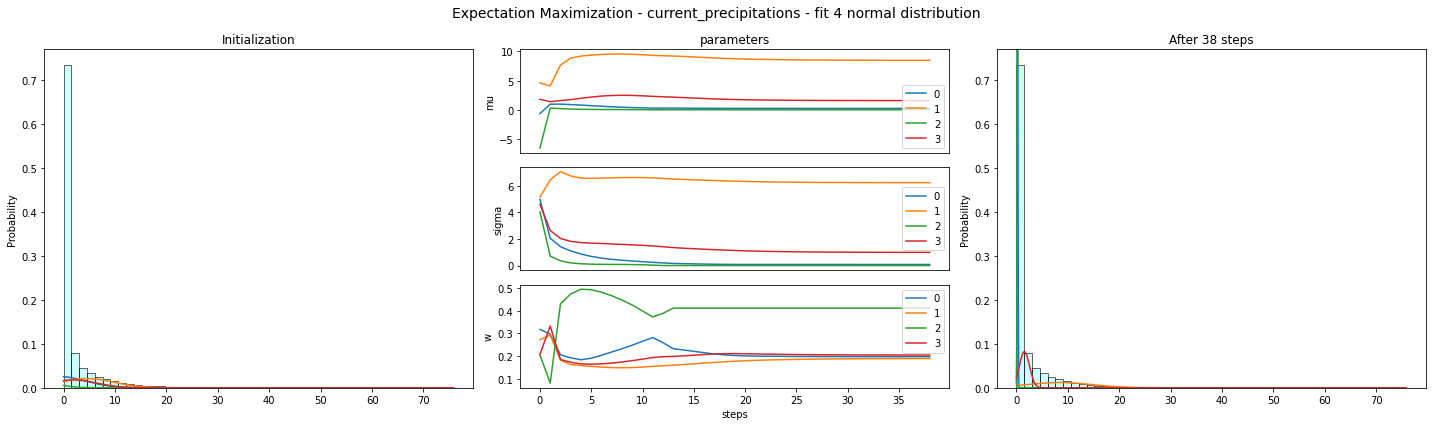

In [6]:
for col in ['wind_speed', 'temperature', 'humidity', 'dew_point', 'current_precipitations'] :
    print("\n\n","="*50,sep="")
    print("\n\t",col)
    print("\n","="*50,"\n\n",sep="")
    for k in range(1,5) :
        em = EM(x=df[col].to_numpy(), nb_dist=k, split_ratio=0.01, threshold=0.001, talk=True)
        t = time.time()
        em.fit(max_iters=1000)
        print("elapsed : {:.2f} s.".format(time.time()-t))
        em.plot_progression(title="Expectation Maximization - {} - fit {} normal distribution".format(col,k))